In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Définition des constantes clés du problème :

In [58]:
r=0.02 #taux d'actualisation
mu=0.2
sigma=0.2 #voltatilité
S0=100 #valeur initiale de l'actif risque 
T=5 #ans
frequence=24*365 #pour l'instant on actualise le prix une fois par heure


## Simulation de l'actif sans risque sur 5 ans :

On prend pour commencer un taux fixe r et une durée N de simulation.

On sait que la valeur au bout d'une durée n de l'actif sans risque sera $S_n^0 = S_k^0*(1+r)^{n-k}$


Pour pouvoir utiliser cela, on crée une fonction triviale qui renvoi la valeur de $S_n^0$ pour tout n. 

In [59]:
def wo_risk(r, n): #n en années
    return np.exp(r*n)

Text(0.5, 1.0, "Evolution du prix de l'actif sans risque, r=0.02")

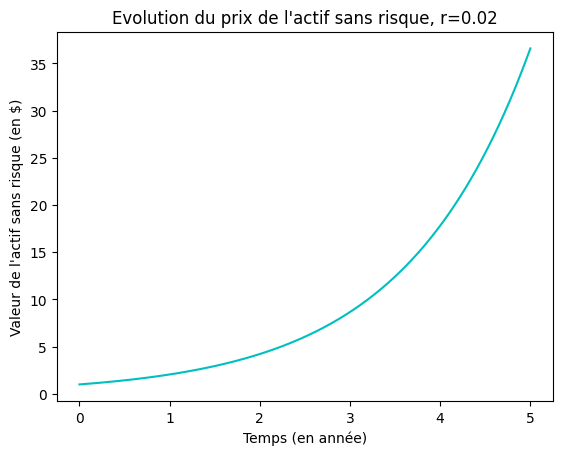

In [60]:
plt.plot(np.linspace(0, 5, 5*24*365),[wo_risk(0.03, k/365 ) for k in range(5*24*365)], 'c')
plt.xlabel("Temps (en année)")
plt.ylabel("Valeur de l'actif sans risque (en $)")
plt.title(f"Evolution du prix de l'actif sans risque, r={r}")

## Simulation de l'actif risqué sur 5 ans :

Pour cela, on considère que l'actif risqué suit un mouvement Brownien.

In [61]:
def black_scholes_add_dst(n): #n en années
    end = n * 24 * 365
    dt=1/365/24
    actif_values=S0*np.ones(end)
    for k in range(1,end):
        actif_values[k] = actif_values[k-1]*(1+mu*dt+sigma*np.random.normal(0,1)*np.sqrt(dt))
    return actif_values

In [62]:
lst_black_scholes = black_scholes_add_dst(5)

Text(0.5, 1.0, "Evolution du prix de l'actif risqué en fonction du temps, mu=0.2, r=0.02, sigma=0.2")

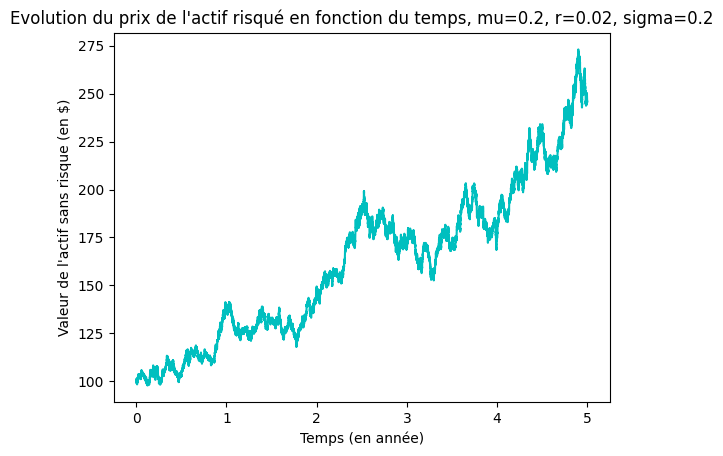

In [63]:
plt.plot(np.linspace(0, 5, 5*365*24),lst_black_scholes, 'c')
plt.xlabel("Temps (en année)")
plt.ylabel("Valeur de l'actif sans risque (en $)")
plt.title(f"Evolution du prix de l'actif risqué en fonction du temps, mu={mu}, r={r}, sigma={sigma}")

In [64]:
actif_risque = lst_black_scholes
actif_sans_risque = [wo_risk(r, i) for i in np.linspace(0, T, frequence*T)]


## Définition de f :

In [65]:
def f_call( S_t, K):
    return max(0, S_t-K)

### Détermination du paramètre N

In [66]:
dt = 1/frequence
N_traj = 100  # nombre de trajectoires qui va évoluer
N_points=frequence*T

# Simulation des trajectoires
def simulateur_trajectoire_brow(N_traj, N_points):
    X = np.zeros((N_points+1, N_traj)) #on initialise la matrice des trajectoires
    for j in range(N_traj):
        for i in range(1, N_points+1):
            dW = np.random.normal(0, np.sqrt(dt))
            X[i,j] = X[i-1,j] + dW
    return X

On a donc maintenant nos trajectoires browniennes, il faut donc calculer les $R^i$ et les $\overline R ^i$.

In [67]:
def calculR_i(t, X, N_traj): 
    R_i = np.zeros(N_traj)
    for k in range(N_traj):
        R_i[k]=(r-sigma**2/2)*(T-t)+sigma*X[int(T-t), k]
    return R_i

In [68]:
def calcul_R_barre(t, X, N_traj):
    R_barre = np.zeros(N_traj)
    for k in range(N_traj):
        R_barre[k]=max([(r-sigma**2/2)*s+sigma*X[s, k] for s in range(0,int(T-t))])
    return R_barre
      

On peut maintenant commencer la simulation.

On fixe tout d'abord t, z et x :

In [69]:
t=1  
z=200
x = 100
K=10

In [70]:
X = simulateur_trajectoire_brow(N_traj, N_points)
lst_R_barre = calcul_R_barre(t, X, N_traj)

In [71]:
lst_R_i = calculR_i(t,X,N_traj) 

In [72]:
def calcul_terme_esperance(x, t, traj):
    if x*np.exp(lst_R_barre[traj])<z:
        return f_call(x*np.exp(lst_R_i[traj]),K)
    return 0

On sait maintenant calculer les termes, on n'a plus qu'à simuler sur N trajectoires.

Pour commencer nous allons prendre N = 100 puis on ajustera en fonction des résultats que l'on obtient.

In [73]:
N = 100
lst_valeur_esp = [calcul_terme_esperance(x, t, k) for k in range(N)]

On calcul désormais la moyenne empirique et la variance empirique.

In [74]:
moyenne_empirique = 1/N*sum(lst_valeur_esp)
variance_empirique = 1/N*sum([(lst_valeur_esp[i]-moyenne_empirique)**2 for i in range(N)])

In [75]:
moyenne_empirique

89.99087078788911

In [76]:
variance_empirique

0.18988003619282726

In [77]:
(2*1.96*np.sqrt(variance_empirique/N_traj))/moyenne_empirique

0.0018981357360765702

On est bien en dessous de 0,05 donc N=100 parait correct.

## Définition de g :

On a maintenant une expression simplifiée de g qui est approximée grâce à la loi des grands nombres.

On prend N=100 d'après notre étude précédente.

In [78]:
N=100 #définition du paramètre N

In [79]:
def g(t,x):
    lst_indicatrices = []
    for i in range(N):
        if x*np.exp(lst_R_barre[i])-z < 0:
            lst_indicatrices.append(1)
        else: 
            lst_indicatrices.append(0)
    to_sum = [f_call(x*np.exp(lst_R_i[i]),K)*lst_indicatrices[i] for i in range(N)]
    return (np.exp(-r*(T-t/(24*365)))/N)*sum(to_sum)

In [80]:
g(t,x)

81.42729307737083

## Implémentation de la stratégie :

On a précédemment déterminé la stratégie de couverture parfaite :

Il faut avoir pour tout t une quantité $\phi_t$ d'actif risqué et $\phi_t^0$ d'actif non risqué.

Ces quantités sont définies par :

$\phi_t = \mathbb{1}_{{t<\tau_z}}*\partial_x g(t, S_t)$

$\phi_t^0 = \mathbb{1}_{{t<\tau_z}} e^{-rt} (g(t, S_t)-\partial_x g(t, S_t)S_t)$



In [81]:
def phi_t(tau_z, S_t, S_t1, t): #S_t plus récent 
    if t<tau_z:
        return (g(t, S_t)-g(t,S_t1))/(S_t-S_t1)
    else:
        return 0

In [82]:
def phi_t_0(tau_z, S_t, S_t1, t):
    if t<tau_z:
        return np.exp(-r*t/(24*365))*(g(t, S_t)-((g(t, S_t)-g(t,S_t1 ))/(S_t-S_t1))*S_t)
    return 0

## Valeur du portefeuille :

In [83]:
def portefeuille(tau_z, S_t, S_t1, t):
    return phi_t_0(tau_z, S_t, S_t1, t)*wo_risk(r,t/(24*365))+phi_t(tau_z, S_t, S_t1, t)*actif_risque[int(t)]

## Test sur nos actifs et représentation :

In [84]:
def tau_z(lst,z):
    L = [lst[i]-z for i in range(len(lst))]
    for e in L:
        if e < 0:
            pass
        else:
            return L.index(e)
    return len(lst)


In [85]:
tau_z = tau_z(actif_risque,z)

In [86]:
tau_z

31965

In [87]:
A = [portefeuille(tau_z, actif_risque[i], actif_risque[i-1], i) for i in range(1, len(actif_risque))]

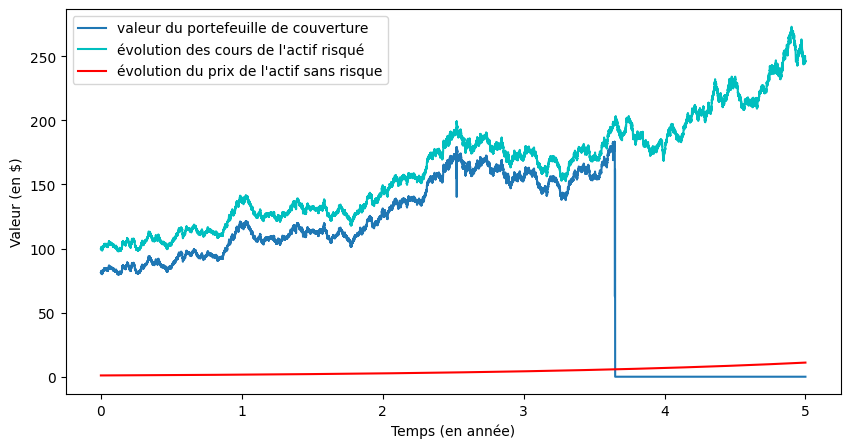

In [88]:
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,T,T*frequence-1),A, label = 'valeur du portefeuille de couverture')
plt.plot(np.linspace(0, T, T*frequence),lst_black_scholes, 'c', label = 'évolution des cours de l\'actif risqué')
plt.plot(np.linspace(0, T, T*frequence),[wo_risk(r, k/365 ) for k in range(T*frequence)], 'r',label = 'évolution du prix de l\'actif sans risque')
plt.xlabel("Temps (en année)")
plt.ylabel("Valeur (en $)")
plt.legend()

In [89]:
lst_qtité_sans_risque = [phi_t_0(tau_z, actif_risque[i], actif_risque[i-1], i) for i in range(1, len(actif_risque))]

In [90]:
lst_qtité_risque = [phi_t(tau_z, actif_risque[i], actif_risque[i-1], i) for i in range(1, len(actif_risque))]

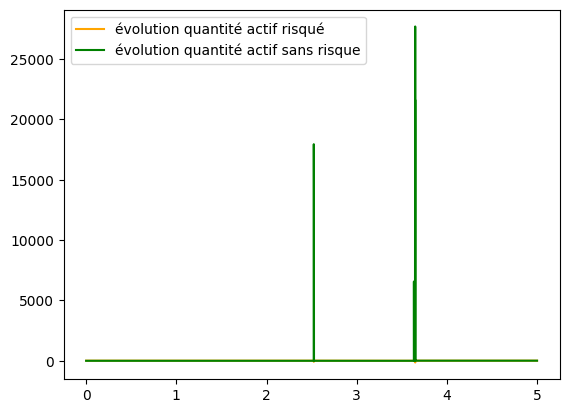

In [91]:
plt.plot(np.linspace(0,T,T*frequence-1),lst_qtité_risque,'orange', label = 'évolution quantité actif risqué ')
plt.plot(np.linspace(0,T,T*frequence-1),lst_qtité_sans_risque,'green', label = 'évolution quantité actif sans risque')
plt.legend()

## Vérification de stratégie autofinancée :

On voit bien qu'à chaque instant on a une valeur de portefeuille positive : la stratégie est bien autofinancée.